<a href="https://colab.research.google.com/github/KonstantinIvanchenko/trafficSignRecognitionTest/blob/master/ts_recogn_tst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)
ClassId, SignName
0, Speed limit (20km/h)
1, Speed limit (30km/h)
2, Speed limit (50km/h)
3, Speed limit (60km/h)
4, Speed limit (70km/h)
5, Speed limit (80km/h)
6, End of speed limit (80km/h)
7, Speed limit (100km/h)
8, Speed limit (120km/h)
9, No passing
10, No passing for vechiles over 3.5 metric tons
11, Right-of-way at the next intersection
12, Priority road
13, Yield
14, Stop
15, No vechiles
16, Vechiles over 3.5 metric tons prohibited
17, No entry
18, General caution
19, Dangerous curve to the left
20, Dangerous curve to the right
21, Double curve
22, Bumpy road
23, Slippery road
24, Road narrows on the right
25, Road work
26, Traffic signals
27, Pedestrians
28, Children crossing
29, Bicycles crossing
30, Beware of ice/snow
31, Wild animals crossing
32, End of all speed and passing limits
33, Turn right ahead
34, Turn left ahead
35, Ahead only
36, Go straight or right
37, Go straight or left
38, Keep right
39, Keep left
40,

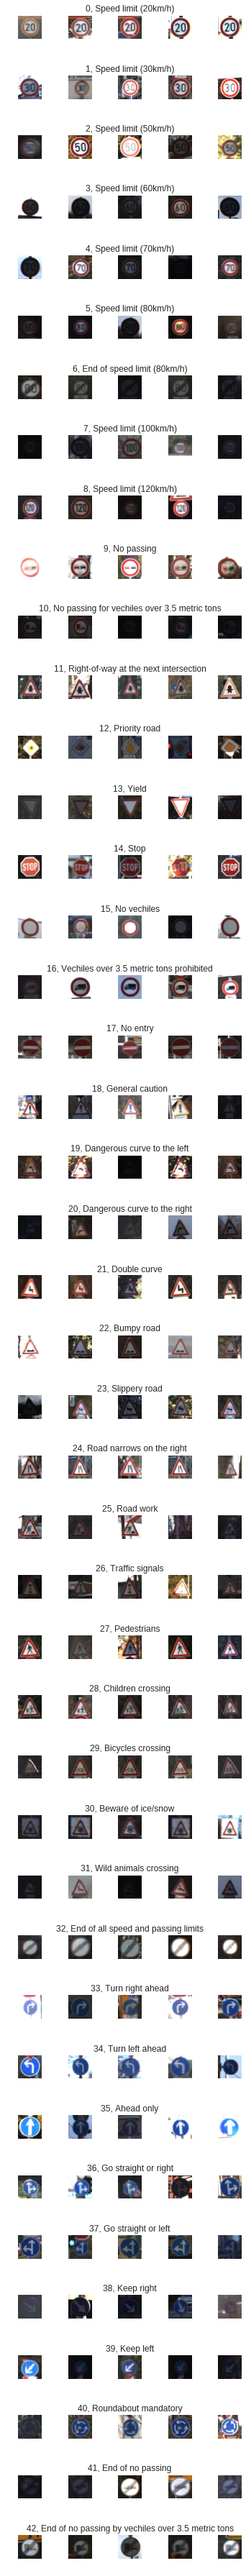

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random

from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import pickle
import csv
import cv2

np.random.seed(0)

# read as binaries from pickled data
# __data is of type 'dict'
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data=pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data=pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data=pickle.load(f)

# load training, validation and test data with labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


sign_class_names = []

# printout existing labels and codes
with open('german-traffic-signs/signnames.csv', newline='') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    new_str = ', '.join(row)
    print(new_str)
    sign_class_names.append(new_str)
      
cols = 5
num_classes = 43
num_of_samples = []

# to categorical
y_train_cat = to_categorical(y_train, 43)
y_val_cat = to_categorical(y_val, 43)
y_test_cat = to_categorical(y_test, 43)

# plot random data samples from loaded data for each class
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
  for j in range(num_classes):
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(sign_class_names[j+1])
      num_of_samples.append(len(x_selected))


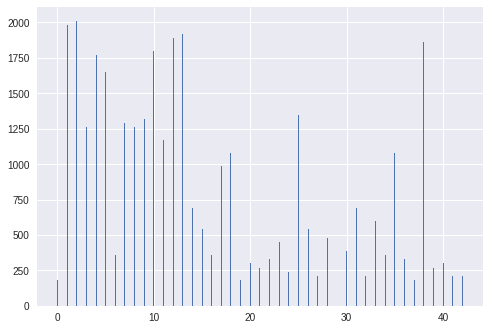

In [0]:
# plot initial data quantity for each class
fig = plt.bar(range(0, num_classes), height=num_of_samples, width = 0.1)
plt.show(fig)

In [0]:
# use data generator for augmenting initial datasets with random alterations by
# width, height, zoom, shear and rotation
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)
# for X_batch, y_batch in

# batches = datagen.flow(X_train, y_train, batch_size=15)
# X_batch, y_batch = next(batches)

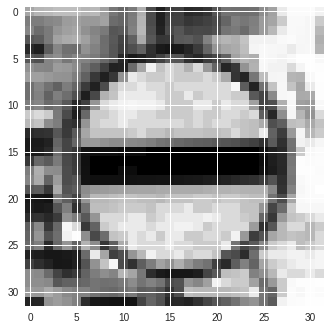

In [0]:
# print(X_train.shape)
# X_train_gr = np.sum(X_train, axis=3, )/(3*255)
# print(X_train_gr)

def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

def hist_equalize(img):
  img = cv2.equalizeHist(img)
  return img

def preprocessing(img):
  img = grayscale(img)
  img = hist_equalize(img)
  img = img /255
  return img

# preprocess each image
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
plt.imshow(X_train[1000])
plt.imshow(X_val[1000])
plt.imshow(X_test[1000])

X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [0]:
def cnn_model():
  model = Sequential()
  # amount of filters - 60
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  # additional layer
  model.add(Conv2D(60, (5,5), activation='relu'))
  
  # we will get (12x12) images after pooling
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  # amount of filters - 30
  model.add(Conv2D(30, (3,3), activation='relu'))
  # additional layer
  model.add(Conv2D(30, (3,3), activation='relu'))
  
  # we will get (4x4) images after pooling
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  # Dropout for reducing overfitting
  model.add(Dropout(0.5))
  
  # add Flatten layer for making data single-dimensional
  model.add(Flatten())
  
  # mlp
  model.add(Dense(500, activation='relu'))
  
  # Dropout for reducing overfitting
  model.add(Dropout(0.5))
  
  # mlp
  model.add(Dense(num_classes, activation='softmax'))
  
  # compile model
  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
                metrics=['accuracy'])
  return model

model = cnn_model()
print(model.summary())

# use fit generator for with previously vreated 'datagen' generator.
# here the validation set generator is not used.
history = model.fit_generator(datagen.flow(X_train, y_train_cat, batch_size=50),
                              steps_per_epoch=2000,
                              epochs=10,
                              validation_data=(X_val, y_val_cat), shuffle=1)

"""
history = model.fit(X_train, y_train_cat, epochs=25, 
                    validation_data=(X_val, y_val_cat),
                   batch_size=400, verbose=1, shuffle=1)
"""



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 30)          0         
__________

'\nhistory = model.fit(X_train, y_train_cat, epochs=25, \n                    validation_data=(X_val, y_val_cat),\n                   batch_size=400, verbose=1, shuffle=1)\n'

Text(0.5, 0, 'epoch')

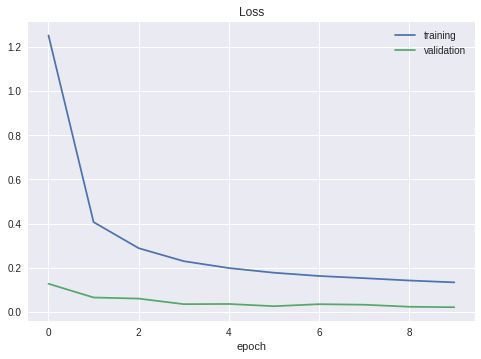

In [0]:
# plot the results of the loss 'categorical_crossentropy' for each epoch.
# It is mean loss for each batch/epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

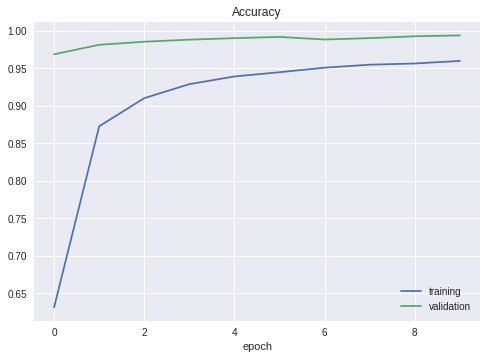

In [0]:
# plot the prediction accuracy at each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
# evaluation of the loss function and corresponding accuracy
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.11023039402957653
Test accuracy: 0.972050673019669


(32, 32)
predicted sign: [23]


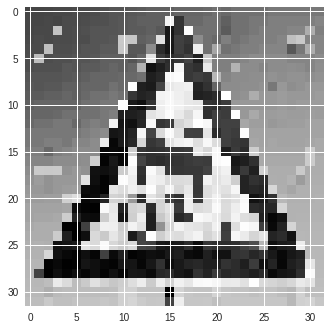

In [0]:
#fetch image
 
import requests
from PIL import Image
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
# Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
 
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))